<img src="UIUC_ZJGSU.png" width="50%">

# Secured Telemetry by Time-Variant Sensing Matrix

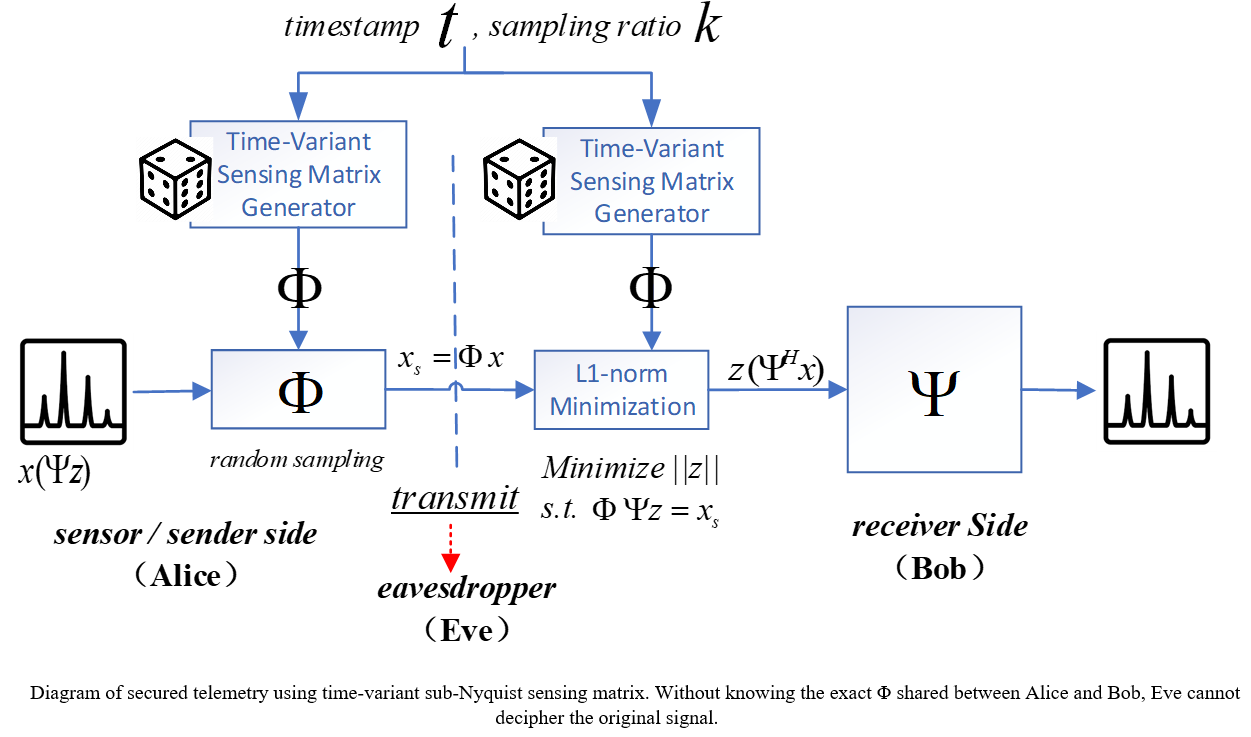

# Install 

This code uses our 'cs1' package (https://github.com/zhangys11/cs1)   

`pip install cs1`

You also need to install our 'qsi-tk' package to use the data I/O functions,  

`pip install qsi-tk`

# Load Data

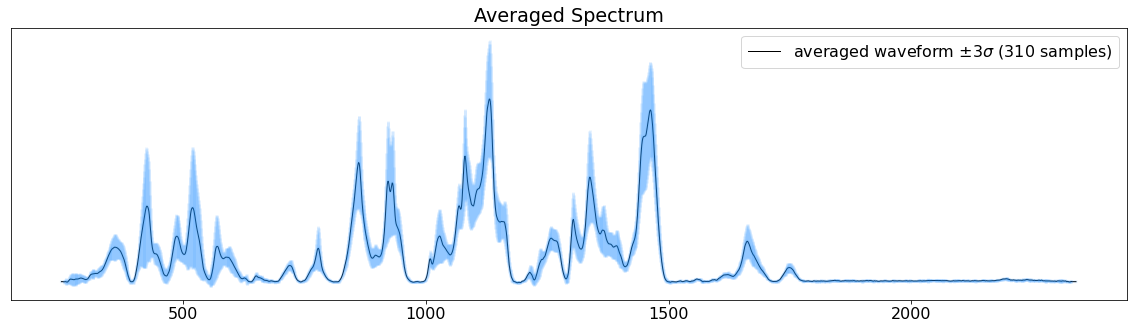

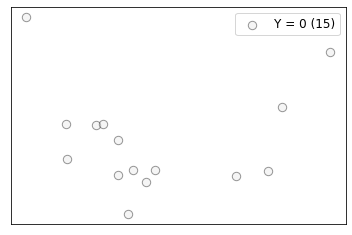

Column Meanings: Raman shift / wavenumber (cm-1). Range: 250~2339
Each row is one sample. 
Total 15 sampless

* Data Source: Compressed Milk Tablet Candy, with Calcium and Vitamin A,D additives
* Source: Heilongjiang Province, China.
-------------------------
Internal Source ID 734b
Edit date: Jan 13, 2020


In [1]:
from qsi import io
X, y, X_names, _ = io.LoadDataSet('milk_tablet_candy')

## Core Compressed Sensing (CS) Process**

Sampling  
$ x_s = \Phi x $

Sparsity hypothesis  
$ x = \Psi z $

Compressed Sensing / sub-Nyquist Sampling   
$ x_s = \Phi \Psi z $

Reconstruction of latent z    
$ minimize \quad  ||z||_1 \quad s.t. \quad     x_s = \Phi \Psi z $

Inverse-transform to orginal space    
$ x = \Psi z $

## Generating Sensing Matrix

In [ ]:
from cs1 import cs

m,n = X.shape
PHI, OMEGA = cs.GetSensingMatrix(n, k = 0.2, s = None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# plt.figure(figsize = (12,3))
plt.matshow(PHI, interpolation='nearest', cmap=cm.Greys)
plt.title('With seed unspecified, each run will get a different result.')
plt.axis('off')

### Conversion between timestamp and seed (integer)

Unix and POSIX measure time as the number of seconds that have passed since 1 January 1970 00:00:00 UT, a point in time known as the Unix epoch. The NT time epoch on Windows NT and later refers to the Windows NT system time in (10^-7)s intervals from 0h 1 January 1601.

In [11]:
s = cs.Time2Seed()
print(s)

1655705518


In [12]:
cs.Seed2Time(s)

'Mon Jun 20 14:11:58 2022'

# Perform CS sensing and reconstruction on the entire dataset

For details of CS, refer to [Compressed Sening.ipynb]

In [13]:
# Load PSIs back from pickle. The pickle is created by cs.Generate_PSIs().
import pickle

m, n = X.shape
file = open('PSIs_' + str(n) + '.pkl','rb')
PSIs = pickle.load(file)
file.close()

<Figure size 432x288 with 0 Axes>

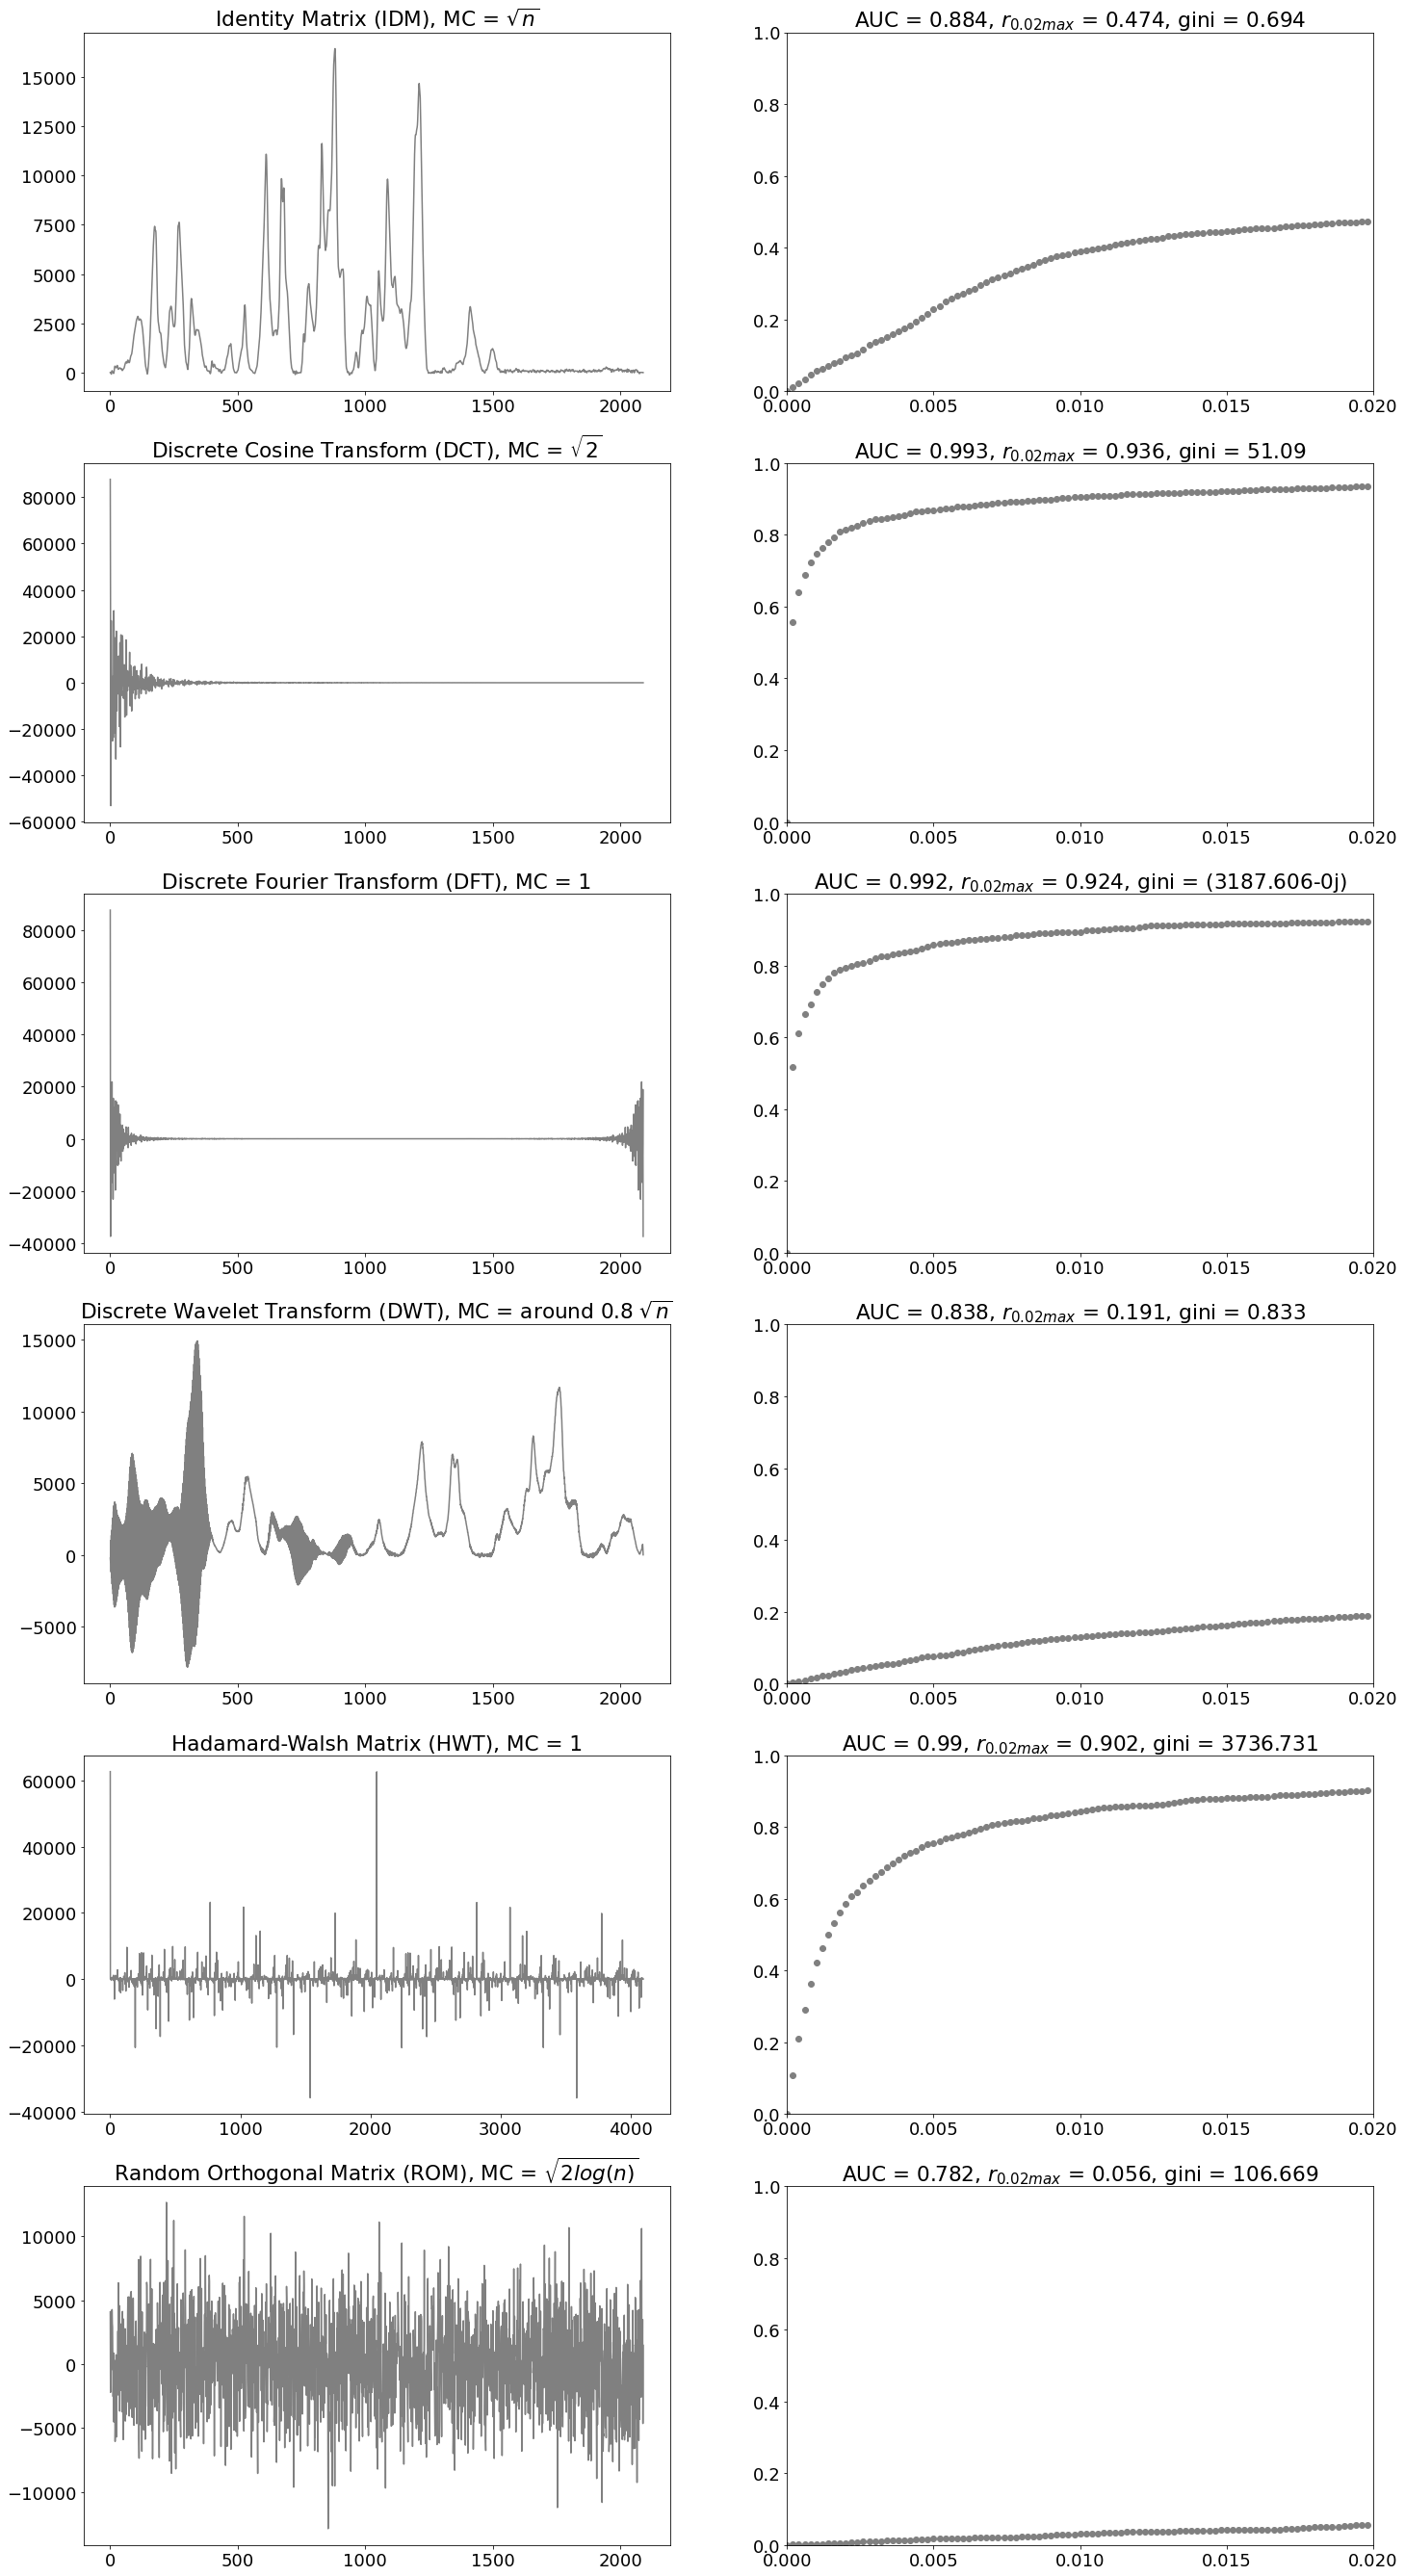

In [78]:
cs.Analyze_Sparsity(X[0], PSIs)

## Visualize all samples



===== Ψ = IDM, k =0.1 ======

Sample 1


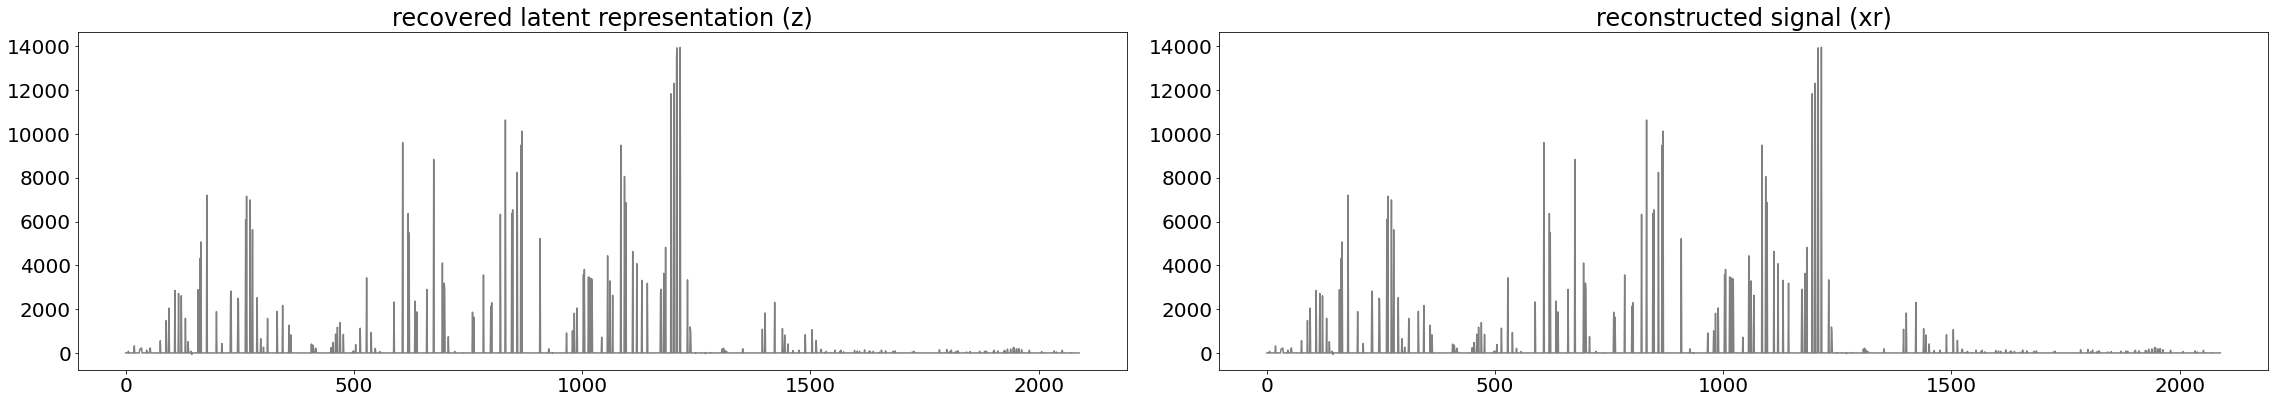

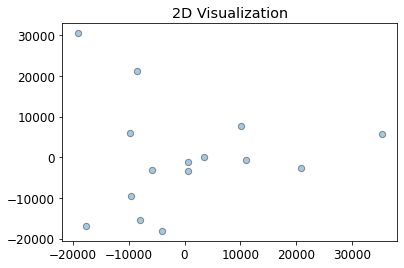



===== Ψ = IDM, k =0.5 ======

Sample 1


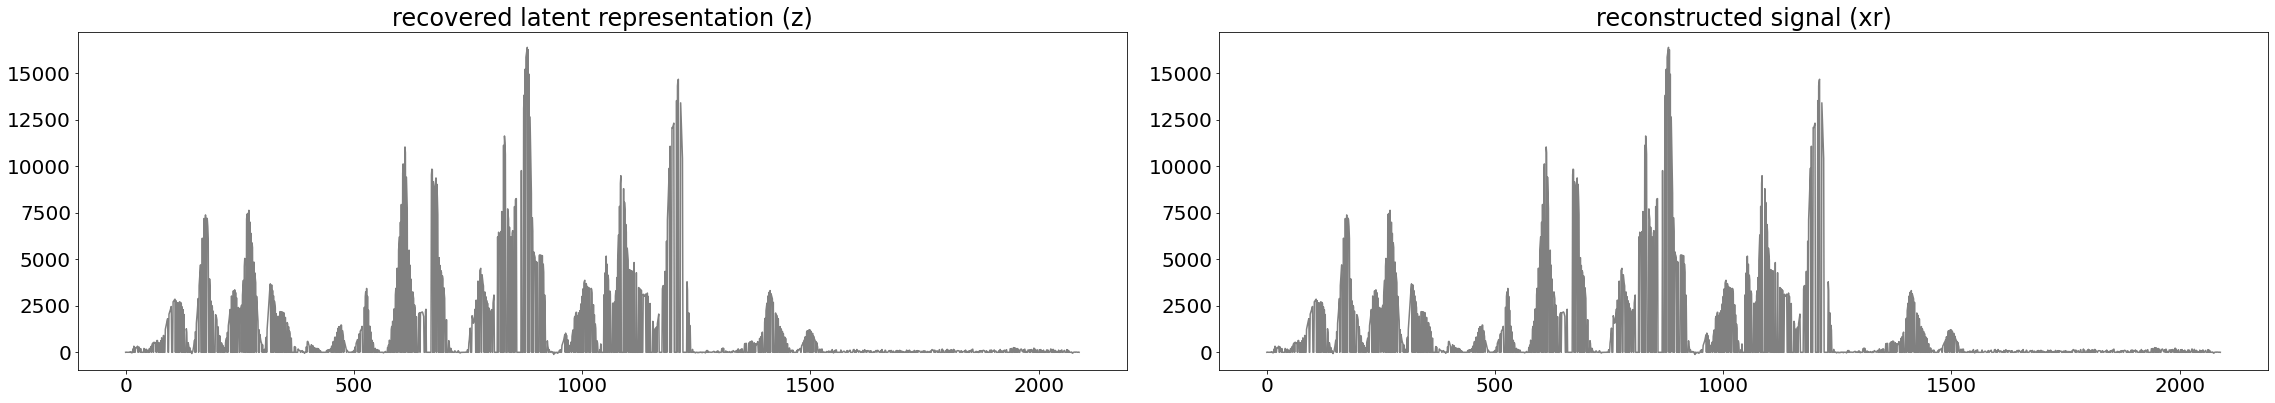

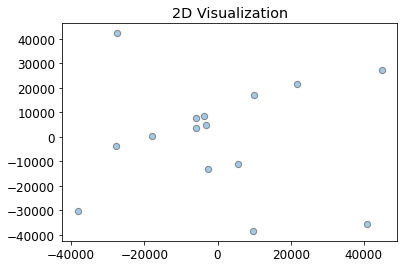



===== Ψ = DCT, k =0.1 ======

Sample 1


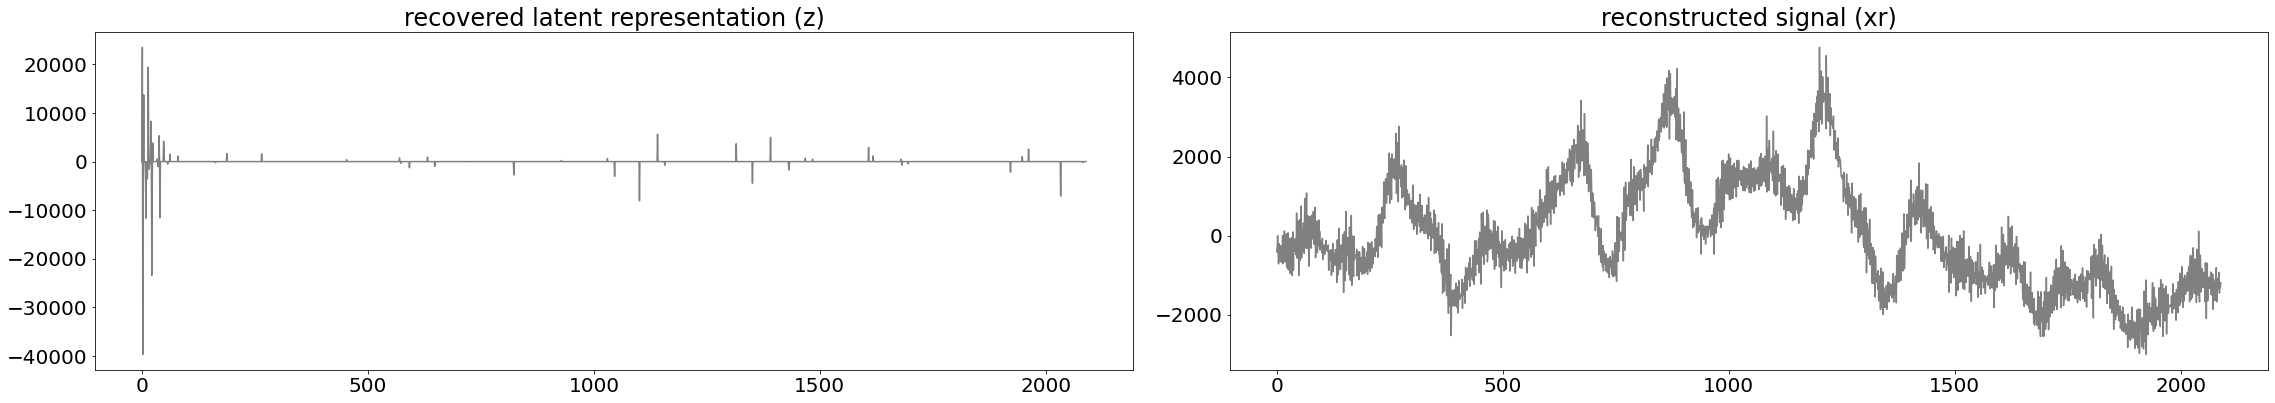

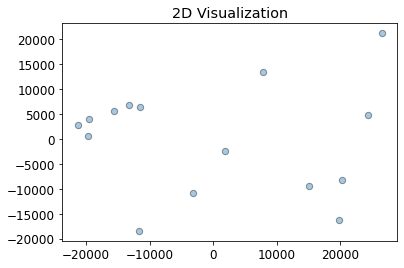



===== Ψ = DCT, k =0.5 ======

Sample 1


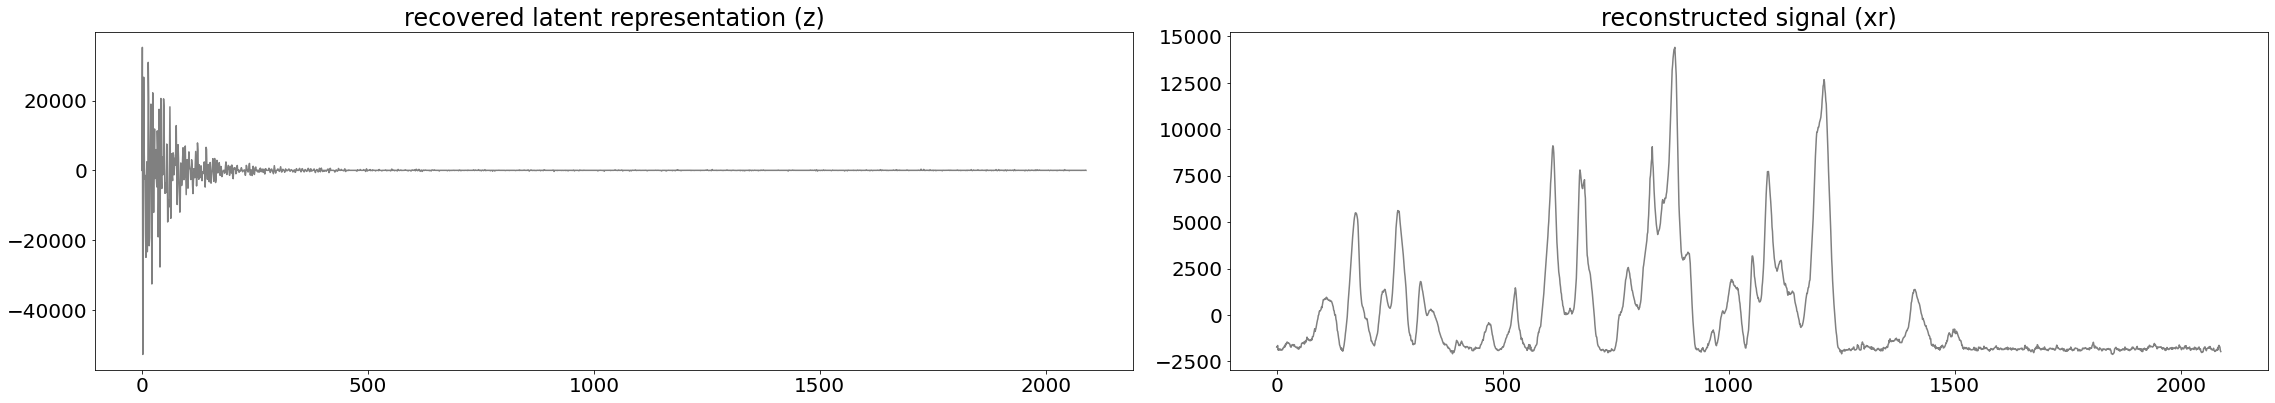

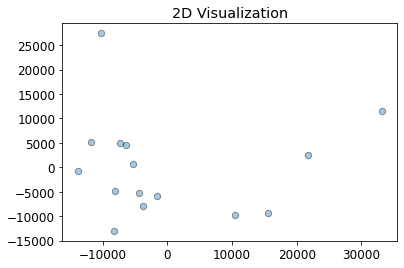

In [79]:
for t in ['IDM', 'DCT']:
    for k in [0.10, 0.50]:        
        _ = cs.Dataset_Sensing_n_Recovery (X, k = k, t = t, solver = 'LASSO', display = 'first')

Several phenomena can be observed. 1) For Ψ = IDM, z = xr. This case equals performing sampling and reconstruction directly in the original space. 2) The reconstruction result of HWT is noisier and “spikier” than DCT and DFT. 3) When k is small (e.g., 0.01, or only 1% information is sampled), the reconstruction error is significant. By increasing k, the error goes down. 4) For k >= 0.1, both DCT and DFT demonstrate decent reconstruction results, though DFT is “spikier” at certain positions than DCT. 

## Best hyper-parameters for the Raman dataset

PSI = "DFT", k = 0.3

# Security Verification

In this part, we simulate a security senario: a hacker intercepts our transmmitted signal xs. He/she tries to guess the sensing matrix and reconstruct the signal with the brute-force method.

<Figure size 432x288 with 0 Axes>

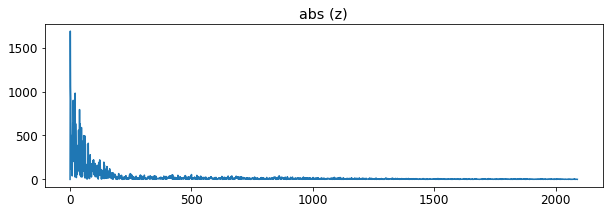

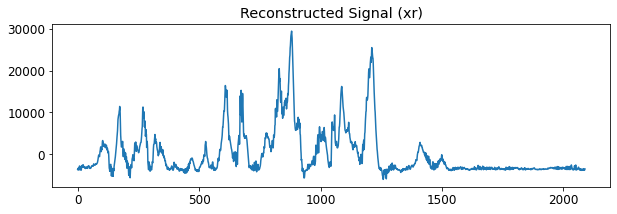

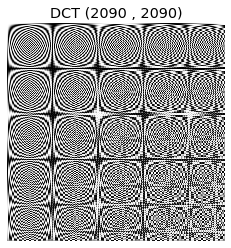

AUC =  0.993 
sparsity =  0.936


In [70]:
k = 0.3
t='DFT'
N = len(X[0])

xs, idx_g = cs.Sensing(X[0], k) # idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.

A = MeasurementMatrix (N, idx_g, t)
xr_g, _ = Recovery (A, xs, t = t)

z_g = dctmtx(N, N) @ X[0]

MAX = abs(max(z_g, key=abs))

auc = 0
for i in range(1000):
    auc += (np.abs(np.array(z_g)) <= (i+1)/1000 * MAX).sum() / len(z_g)        
auc = auc/1000

r = (np.abs(np.array(z_g)) <= 0.02 * MAX).sum() / len(z_g)  # use 0.01 MAX ABS as threshold    

print('AUC = ', round(auc, 3), '\nsparsity = ', round(r, 3))

idx is the sensing indices. It is an eqaulivalent representation for the senging matrix.   
During the data transmission, idx is not transfered (will be generated by the internal TVSMG on both sides).   

With the intercepted signal xs, the hacker try to guess the sensing matrix (idx).  

In [45]:
import itertools
from math import factorial, log10

t = 'dft'
N = len(x)
K = len(xs)
# candidate_idx = list(itertools.combinations(range(N), K))
# print( len(candidate_idx) )

print('N = ', N, ', K ‘= ', K)
LOG10C = log10(factorial(N)) - log10(factorial(N - K)) 
print('A(N,K) in log10 = ', LOG10C ) 
print('Total years needed to iterate all combinations (in log10) = ', LOG10C - log10(3600 * 24 * 365.25))

N =  2090 , K ‘=  627
A(N,K) in log10 =  2036.1280922561273
Total time needed to iterate all combinations (log10 years) =  2028.6289882890421


Each iteration costs 1.1 second on the current workstation. CPU: 2.2G × 6 Cores, Memory: 16 GB

In [48]:
import random
from tqdm import tqdm

# randomly pick ITER sensing matrix to test the reconstruction
ITER = 100000

BEST_IDX = []
MAX_R = 0
MAX_AUC = 0
BEST_XR = None
BEST_Z = None
t = 'DCT'

for i in tqdm( range(ITER) ):
    idx = random.sample(range(N), K)
    A = MeasurementMatrix(N, idx, t)
    xr, z = Recovery (A, xs t = t, silent = True)
    
    
    MAX = abs(max(z, key=abs))
    thresholds = np.array(range(100)) / 5000
    
    auc = 0
    for i in range(1000):
        auc += (np.abs(np.array(z)) <= (i+1)/1000 * MAX).sum() / len(z)        
    auc = auc/1000
    
    r = (np.abs(np.array(z)) <= 0.02 * MAX).sum() / len(z)  # use 0.01 MAX ABS as threshold    
    if (MAX_R < r):
        MAX_R = r
        MAX_AUC = auc
        BEST_IDX = idx
        BEST_XR = xr
        BEST_Z = z

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [8:48:12<00:00,  3.16it/s]


AUC =  0.933 
sparsity =  0.285


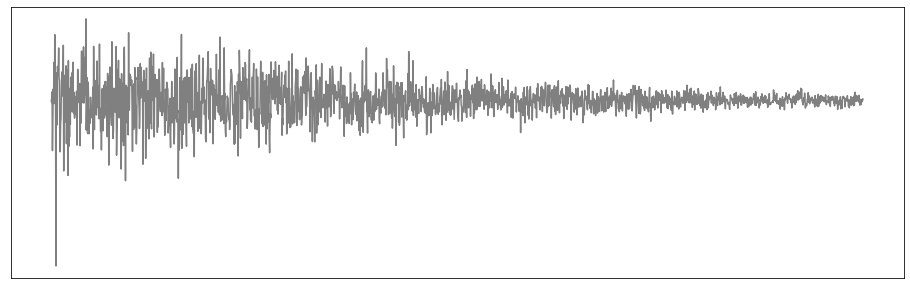

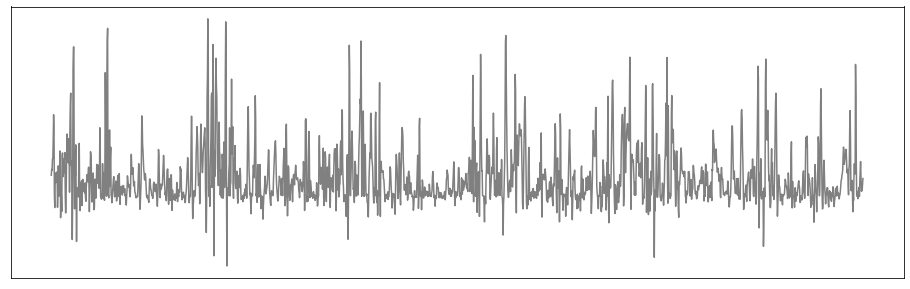

In [49]:
# the best result after 5000 iterations

print('AUC = ', round(MAX_AUC, 3), '\nsparsity = ', round(MAX_R, 3))

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=FIGSIZE)
plt.plot(X_names, BEST_Z, color='gray')
# plt.title('reconstructed signal in the latent space (z)')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X_names, BEST_XR, color='gray')
# plt.title('reconstructed signal (xr)')
plt.xticks([])
plt.yticks([])
plt.show()

In [73]:
# plot the dynamic curve agaist n and k
from math import factorial, log10

def draw_N_Phi(N_range):

    plt.figure(figsize=(16,12))

    N = N_range

    for k in [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
        
        A = []
        for n in N:
            K = round(n * k)
            a = log10(factorial(n)) - log10(factorial(n - K))
            A.append(a)
        plt.plot(N, A, label = 'k = ' + str(k) )

    plt.ylabel('search space ($ N_\Phi $) in log 10')
    plt.xlabel('signal dimensionality (n)')
    # plt.xticks([])
    # plt.yticks([])
    plt.legend()
    plt.show()

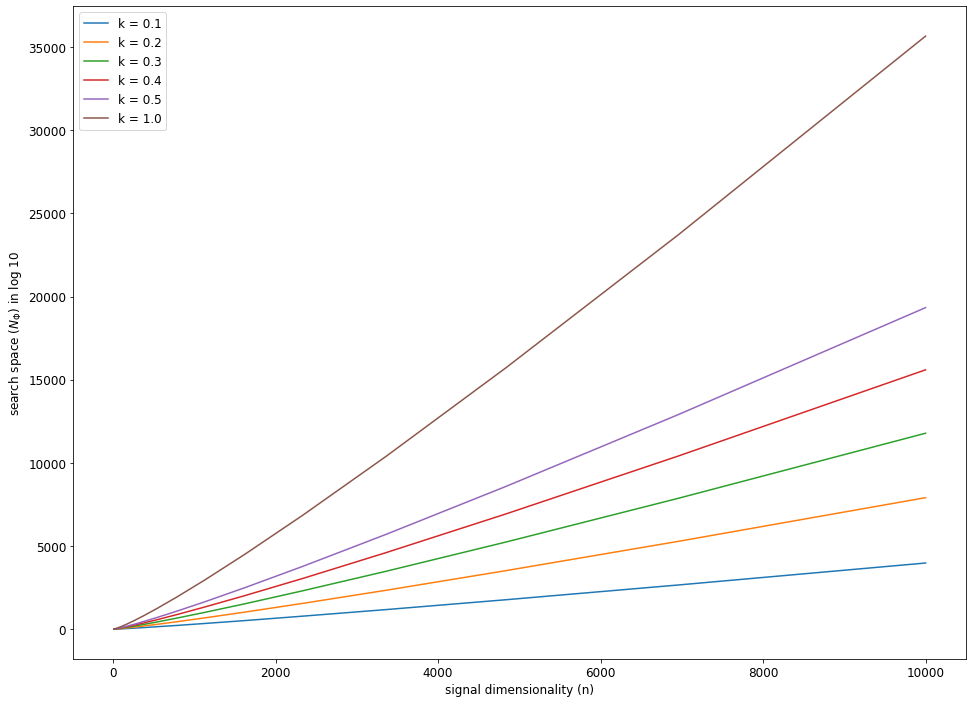

In [74]:
draw_N_Phi(np.round( np.logspace(1,4, 20) ))

# Appendix

## 1. Github (http://github.com/zhangys11/cs1)

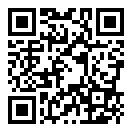

## 2. A CS web demo (http://qsi.zhangys.org.cn/CS)

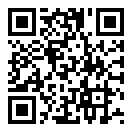

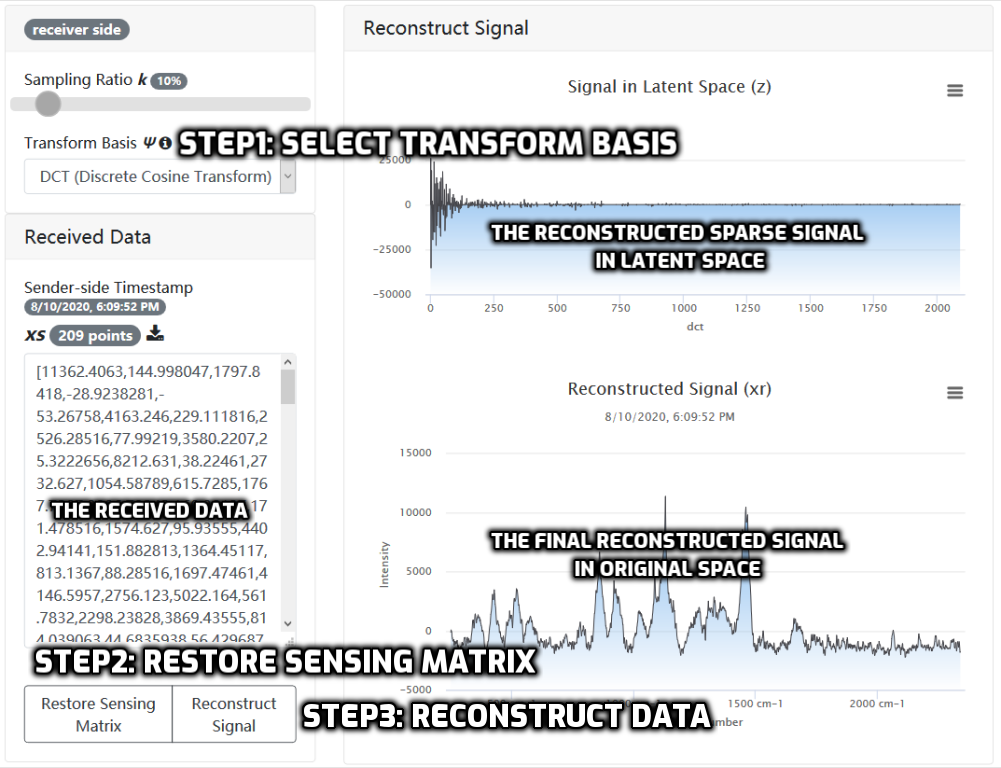